In [1]:
from PIL import Image
from torchvision import transforms
from src.backbone import Backbone
from src.fpn import FPN
from src.rpn import RPN
from src.head import DetectionHead
import torch

from src.utils import *

/home/ubuntu/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Test all the individual functionality required for the training pipeline

In [2]:
output_layer_map = {
    'conv3': 16,
    'conv4': 23,
    'conv5': 30
}

backbone = Backbone(output_layer_map)

dog_img = Image.open("../data/dog.png")

/home/ubuntu/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


conv3 16
conv4 23
conv5 30


In [13]:
preprocess = transforms.Compose([
    transforms.Resize((600, 600)),      
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],     # ImageNet mean
        std=[0.229, 0.224, 0.225]       # ImageNet std
    )
])

preprocessed_img = preprocess(dog_img).unsqueeze(0)

preprocessed_img.size()

torch.Size([1, 3, 600, 600])

In [14]:
features = backbone(preprocessed_img)

In [15]:
features.keys()

dict_keys(['conv3', 'conv4', 'conv5'])

In [16]:
print(features['conv3'].size()), print(features['conv4'].size()), print(features['conv5'].size())

torch.Size([1, 256, 75, 75])
torch.Size([1, 512, 37, 37])
torch.Size([1, 512, 18, 18])


(None, None, None)

In [17]:
fpn = FPN()
fpn_features = fpn(features)
print(fpn_features['conv3'].size()), print(fpn_features['conv4'].size()), print(fpn_features['conv5'].size())

torch.Size([1, 256, 75, 75])
torch.Size([1, 256, 37, 37])
torch.Size([1, 256, 18, 18])


(None, None, None)

In [18]:
rpn = RPN()
rpn_out = dict()
for k, v in fpn_features.items():
    rpn_out[k] = rpn(v)

In [19]:
rpn_out['conv3'][0].size(), rpn_out['conv4'][0].size(), rpn_out['conv5'][0].size(), rpn_out['conv3'][1].size(), rpn_out['conv4'][1].size(), rpn_out['conv5'][1].size()

(torch.Size([1, 18, 75, 75]),
 torch.Size([1, 18, 37, 37]),
 torch.Size([1, 18, 18, 18]),
 torch.Size([1, 36, 75, 75]),
 torch.Size([1, 36, 37, 37]),
 torch.Size([1, 36, 18, 18]))

In [21]:
img_shape = (600, 600)
feature_map_key = 'conv4'
rpn_deltas = torch.cat([rpn_out[feature_map_key][1]] * 4, dim=0)
feature_map = fpn_features[feature_map_key]
anchors = generate_anchors()

print(rpn_deltas.size(), feature_map.size(), anchors.shape)
sorted_rpn_keys = sorted(rpn_out.keys())


layer_to_shifted_anchors = dict()
for k in sorted_rpn_keys:
    print(rpn_out[k][0].size(2), rpn_out[k][0].size(3), img_shape[0] // rpn_out[k][0].size(2))
    layer_to_shifted_anchors[k] = torch.from_numpy(shift((anchors), rpn_out[k][0].size(2), rpn_out[k][0].size(3), img_shape[0] // rpn_out[k][0].size(2))).to(rpn_out[k][1].device).float()

all_rpn_deltas = torch.cat([collect_rpn_deltas(rpn_out[k][1]) for k in sorted_rpn_keys], dim=0)
print(all_rpn_deltas.size())
rois = torch.cat([generate_rois(rpn_out[k][1], layer_to_shifted_anchors[k], img_shape) for k in sorted_rpn_keys], dim=0)
scores = torch.cat([get_scores(rpn_out[k][0]) for k in sorted_rpn_keys], dim=0)
# rois = generate_rois(rpn_deltas, anchors, img_shape)
print(rois.size(), scores.size())

rpn_gt_batch0 = torch.tensor([
    [0, 50, 50, 150, 150, 1],
    [0, 200, 200, 300, 300, 1]
], dtype=torch.float32)
rpn_gt_batch1 = torch.tensor([
    [1, 100, 100, 200, 200, 1],
    [1, 250, 250, 350, 350, 1]
], dtype=torch.float32)
gt = torch.cat([rpn_gt_batch0, rpn_gt_batch1], dim=0)

rpn_sampled_proposals, rpn_sampled_scores, rpn_sampled_labels, rpn_sampled_bbox_targets, rpn_sampled_indices = matching_and_sampling(rois, scores, gt, 128)
rpn_sampled_deltas = all_rpn_deltas[rpn_sampled_indices]
print(rpn_sampled_proposals.size(), rpn_sampled_scores.size(), rpn_sampled_labels.size(), rpn_sampled_bbox_targets.size(), rpn_sampled_deltas.size())

unique_batches = rois[:, 0].unique()
all_proposals = []
all_scores = []

for batch_idx in unique_batches:
    batch_mask = rois[:, 0] == batch_idx
    batch_rois = rois[batch_mask]
    batch_scores = scores[batch_mask]

    # Perform NMS on the batch
    keep = nms(batch_rois, batch_scores[:, 1])
    batch_rois = batch_rois[keep]
    batch_scores = batch_scores[keep]

    _, sorted_indices = torch.sort(batch_scores[:, 1], descending=True)
    sorted_proposals = batch_rois[sorted_indices]
    sorted_scores = batch_scores[sorted_indices]

    K = 2000  # for example, adjust K based on your use case
    topk_proposals = sorted_proposals[:K]
    topk_scores = sorted_scores[:K]

    all_proposals.append(topk_proposals)
    all_scores.append(topk_scores)

print(all_proposals[0].size(), all_scores[0].size())
all_proposals = torch.cat(all_proposals, dim=0)
all_scores = torch.cat(all_scores, dim=0)
print(all_proposals.size(), all_scores.size())

all_proposals = all_proposals.detach()
all_scores = all_scores.detach()

gt_batch0 = torch.tensor([
    [0, 50, 50, 150, 150, 1],
    [0, 200, 200, 300, 300, 2]
], dtype=torch.float32)
gt_batch1 = torch.tensor([
    [1, 100, 100, 200, 200, 1],
    [1, 250, 250, 350, 350, 2]
], dtype=torch.float32)
gt = torch.cat([gt_batch0, gt_batch1], dim=0)

sampled_proposals, sampled_scores, sampled_labels, sampled_bbox_targets, _ = matching_and_sampling(all_proposals, all_scores, gt, 128)

print(sampled_proposals.size(), sampled_scores.size(), sampled_labels.size(), sampled_bbox_targets.size())

pooled_height, pooled_width = 3, 3

levels = sorted([int(x[-1]) for x in rpn_out.keys()])
aligned_proposals = perform_roi_align(levels, sampled_proposals, fpn_features, pooled_height, pooled_width, img_shape)

print(aligned_proposals.size())

torch.Size([4, 36, 37, 37]) torch.Size([1, 256, 37, 37]) (9, 4)
75 75 8
37 37 16
18 18 33
torch.Size([65862, 5])
torch.Size([65862, 5]) torch.Size([65862, 2])
torch.Size([128, 5]) torch.Size([128, 2]) torch.Size([128]) torch.Size([128, 4]) torch.Size([128, 5])
torch.Size([1620, 5]) torch.Size([1620, 2])
torch.Size([1620, 5]) torch.Size([1620, 2])
torch.Size([128, 5]) torch.Size([128, 2]) torch.Size([128]) torch.Size([128, 4])
torch.Size([128, 256, 3, 3])


In [11]:
N, C, H, W = aligned_proposals.size()
num_classes = 4

head = DetectionHead(in_channels=C, pooled_height=H, pooled_width=W, num_classes=num_classes)

cls_scores, bbox_deltas = head(aligned_proposals)

print(cls_scores.size(), bbox_deltas.size())

torch.Size([128, 5]) torch.Size([128, 16])


In [12]:
rpn_cls_loss, rpn_bbox_loss = rpn_loss_fn(rpn_sampled_deltas, rpn_sampled_scores, rpn_sampled_labels, rpn_sampled_bbox_targets)
print(sampled_proposals.size(), sampled_scores.size(), sampled_labels.size(), sampled_bbox_targets.size())
det_cls_loss, det_bbox_loss = det_loss_fn(bbox_deltas, cls_scores, sampled_labels, sampled_bbox_targets, num_classes)
print(rpn_cls_loss, rpn_bbox_loss, det_cls_loss, det_bbox_loss)

torch.Size([128, 5]) torch.Size([128, 2]) torch.Size([128]) torch.Size([128, 4])
tensor(0.8114, grad_fn=<NllLossBackward0>) tensor(0.4422, grad_fn=<DivBackward0>) tensor(1.5976, grad_fn=<NllLossBackward0>) tensor(0.1619, grad_fn=<DivBackward0>)


Load dataset and experiment

In [11]:
import datasets

In [18]:
ds = datasets.load_dataset("rishitdagli/cppe-5")
train_ds = ds['train']
val_ds = ds['test']

In [19]:
mapped_train_ds = train_ds.map(filter_bboxes_in_sample)
filtered_train_ds = mapped_train_ds.filter(lambda sample: len(sample["objects"]["bbox"]) > 0)

Filter: 100%|██████████| 1000/1000 [00:12<00:00, 81.26 examples/s]


In [20]:
for el in filtered_train_ds:
    for bbox in el['objects']['bbox']:
        x, y, w, h = bbox
        x1, y1, x2, y2 = x, y, x+w, y+h
        if (x1 < 0 or x1 >= el['width']) or (y1 < 0 or y1 >= el['height']):
            print(bbox, el['width'], el['height'])

# train_ds[0]

In [4]:
ds['train'].features['objects'].feature['category'].names

['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask']

In [5]:
# import torch
# from torchvision.ops import box_convert
# from torchvision.utils import draw_bounding_boxes
# from torchvision.transforms.functional import pil_to_tensor, to_pil_image

# train_ds = ds['train']
# example = train_ds[20]
# categories = train_ds.features['objects'].feature['category']
# boxes_xywh = torch.tensor(example['objects']['bbox'])
# boxes_xyxy = box_convert(boxes_xywh, 'xywh', 'xyxy')
# labels = [categories.int2str(x) for x in example['objects']['category']]
# print(labels)
# to_pil_image(
#     draw_bounding_boxes(
#         pil_to_tensor(example['image']),
#         boxes_xyxy,
#         colors="red",
#         labels=labels,
#     )
# )

Write training pipeline

In [1]:
from PIL import Image
from torchvision import transforms
from src.backbone import Backbone
from src.fpn import FPN
from src.rpn import RPN
from src.head import DetectionHead
import torch
import datasets

from src.utils import *

/home/ubuntu/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [2]:
ds = datasets.load_dataset("rishitdagli/cppe-5")
train_ds = ds['train']
val_ds = ds['test']

In [3]:
mapped_train_ds = train_ds.map(filter_bboxes_in_sample)
filtered_train_ds = mapped_train_ds.filter(lambda sample: len(sample["objects"]["bbox"]) > 0)

mapped_val_ds = val_ds.map(filter_bboxes_in_sample)
filtered_val_ds = mapped_val_ds.filter(lambda sample: len(sample["objects"]["bbox"]) > 0)

Filter: 100%|██████████| 29/29 [00:00<00:00, 190.49 examples/s]


In [4]:
import torch.optim as optim

output_layer_map = {
    'conv3': 16,
    'conv4': 23,
    'conv5': 30
}

layer_size_map = {
    'conv3': (75, 75),
    'conv4': (37, 37),
    'conv5': (18, 18)
}

C = 256
pooled_height, pooled_width = 7, 7
num_classes = len(ds['train'].features['objects'].feature['category'].names)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = Backbone(output_layer_map).to(device)
fpn = FPN().to(device)
rpn = RPN().to(device)
head = DetectionHead(in_channels=C, pooled_height=pooled_height, pooled_width=pooled_width, num_classes=num_classes).to(device)

optimizer = optim.Adam(
    list(backbone.parameters()) +
    list(fpn.parameters()) +
    list(rpn.parameters()) +
    list(head.parameters()),
    lr=1e-4
)

/home/ubuntu/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


conv3 16
conv4 23
conv5 30


In [ ]:
from tqdm import tqdm
import logging
from tqdm import tqdm
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
# train_log_filename = f"train_metrics_{timestamp}.log"
train_log_filename = "train_metrics.log"
# val_log_filename = f"val_metrics_{timestamp}.log"
val_log_filename = "val_metrics.log"
log_dir = 'logs'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

logging.basicConfig(
    filename=os.path.join(log_dir, train_log_filename),  # Log file name
    filemode='w',                  # Append mode; use 'w' to overwrite each time
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

train_logger = logging.getLogger("train")
val_logger = logging.getLogger("validation")
val_logger.setLevel(logging.INFO)
if val_logger.hasHandlers():
    val_logger.handlers.clear()
val_file_handler = logging.FileHandler(os.path.join(log_dir, val_log_filename), mode="w")
val_file_handler.setLevel(logging.INFO)
val_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
val_file_handler.setFormatter(val_formatter)
val_logger.addHandler(val_file_handler)
val_logger.propagate = False  # Prevent propagation to root logger

# torch.autograd.set_detect_anomaly(True)

checkpoint_dir = 'checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

train_dataset = DetectionDataset(filtered_train_ds, transform_pipeline, preprocess)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataset = DetectionDataset(filtered_val_ds, transform_pipeline, preprocess)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=4, shuffle=False)

img_shape = (600, 600)
anchors = generate_anchors()

layer_to_shifted_anchors = dict()
for k in layer_size_map.keys():
    layer_h, layer_w = layer_size_map[k]
    layer_to_shifted_anchors[k] = torch.from_numpy(shift((anchors), layer_h, layer_w, img_shape[0] // layer_h)).to(device).float()

num_epochs = 10
for epoch in range(num_epochs):
    train_loop(1, train_dataloader, backbone, fpn, rpn, head, optimizer, device,
               layer_to_shifted_anchors, img_shape, num_classes, pooled_height, pooled_width, train_logger)
    print(f'Starting Validation for epoch {epoch+1}')
    validation_loop(val_dataloader, backbone, fpn, rpn, head, device,
                    layer_to_shifted_anchors, img_shape, num_classes, pooled_height, pooled_width, val_logger)
    
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pth")
    torch.save({
        'epoch': epoch + 1,
        'backbone_state_dict': backbone.state_dict(),
        'fpn_state_dict': fpn.state_dict(),
        'rpn_state_dict': rpn.state_dict(),
        'head_state_dict': head.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)
    print(f"Saved checkpoint for epoch {epoch+1} at {checkpoint_path}")

Saved checkpoint for epoch 1 at checkpoints/model_epoch_1.pth
Saved checkpoint for epoch 2 at checkpoints/model_epoch_2.pth
Saved checkpoint for epoch 3 at checkpoints/model_epoch_3.pth
Saved checkpoint for epoch 4 at checkpoints/model_epoch_4.pth
Saved checkpoint for epoch 5 at checkpoints/model_epoch_5.pth
Saved checkpoint for epoch 6 at checkpoints/model_epoch_6.pth
Saved checkpoint for epoch 7 at checkpoints/model_epoch_7.pth
Saved checkpoint for epoch 8 at checkpoints/model_epoch_8.pth
Saved checkpoint for epoch 9 at checkpoints/model_epoch_9.pth
Saved checkpoint for epoch 10 at checkpoints/model_epoch_10.pth


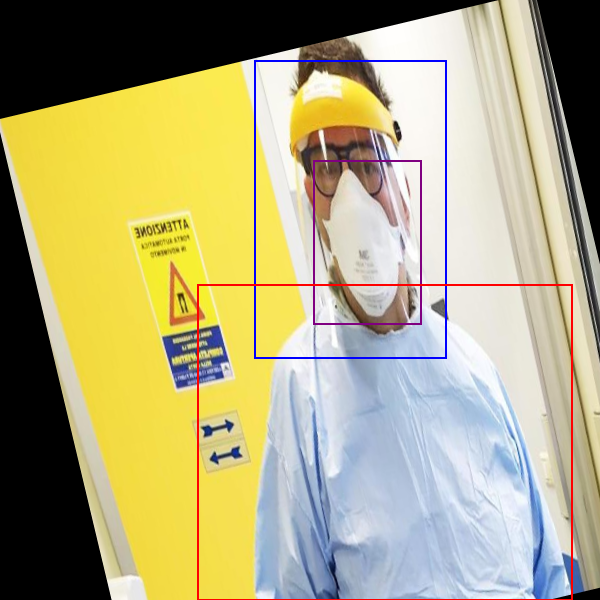

In [48]:
from PIL import ImageDraw

sample = dataset[39][1]
image = sample['augmented_image'].copy()
draw = ImageDraw.Draw(image)

boxes = sample['boxes']
labels = sample['labels']

# Define some colors. You can customize these.
colors = ["red", "blue", "green", "yellow", "purple", "orange"]

for i in range(boxes.size(0)):
    # Convert the box to a list of numbers.
    x, y, w, h = boxes[i].tolist()
    # Compute bottom-right coordinates.
    x2, y2 = x + w, y + h

    # Choose a color based on label (or you can define a mapping from label to color).
    label = int(labels[i].item())
    color = colors[label % len(colors)]

    # Draw the rectangle.
    draw.rectangle([x, y, x2, y2], outline=color, width=2)

image